In [1]:
!nvidia-smi

Sun Jan  1 08:40:42 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    28W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!python -V

Python 3.8.16


In [3]:
!python -c "from tensorflow.python.client import device_lib; print(device_lib.list_local_devices())"

2023-01-01 08:40:49.053950: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8287997851677474865
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14415560704
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12544460932592842856
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [4]:
%cd /content/drive/MyDrive/Colab\ Notebooks/experimentation/language-style-transfer/code

/content/drive/MyDrive/Colab Notebooks/experimentation/language-style-transfer/code


In [5]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd

pd.set_option('display.max_rows', 200)

In [6]:
DATA_DIR = Path('../../data')
TRAIN_PAIR = 'eo850-en8000'
DEV_PAIR = 'eo-en'

TRAIN_DIR = DATA_DIR / 'train' / TRAIN_PAIR
DEV_DIR = DATA_DIR / 'dev' / DEV_PAIR
TEST_DIR = DATA_DIR / 'test' / DEV_PAIR
OUTPUT_DIR = Path('../../output') / TRAIN_PAIR / 'default'

OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

In [7]:
!TF_CPP_MIN_LOG_LEVEL=2 python style_transfer.py \
    --train {TRAIN_DIR}/train \
    --dev {DEV_DIR}/dev \
    --output {OUTPUT_DIR}/dev \
    --vocab {DATA_DIR}/vocab \
    --model {OUTPUT_DIR}/model \
    --steps_per_checkpoint 125

Instructions for updating:
non-resource variables are not supported in the long term
Instructions for updating:
non-resource variables are not supported in the long term
------------------------------------------------
{   'batch_size': 64,
    'beam': 1,
    'dev': '../../data/dev/eo-en/dev',
    'dim_emb': 100,
    'dim_y': 200,
    'dim_z': 500,
    'dropout_keep_prob': 0.5,
    'embedding': '',
    'filter_sizes': '1,2,3,4,5',
    'gamma_decay': 1,
    'gamma_init': 0.1,
    'gamma_min': 0.1,
    'learning_rate': 0.0005,
    'load_model': False,
    'max_epochs': 20,
    'max_seq_length': 20,
    'max_train_size': -1,
    'model': '../../output/eo850-en8000/default/model',
    'n_filters': 128,
    'n_layers': 1,
    'online_testing': False,
    'output': '../../output/eo850-en8000/default/dev',
    'rho': 1,
    'steps_per_checkpoint': 125,
    'test': '',
    'train': '../../data/train/eo850-en8000/train',
    'vocab': '../../data/vocab'}
-----------------------------------------

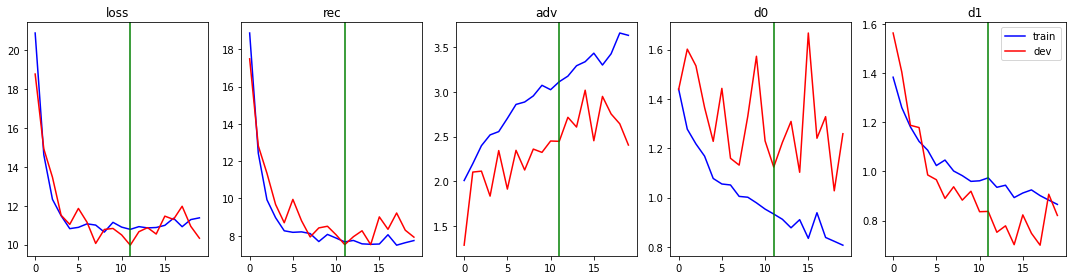

In [9]:
df_train = pd.read_csv(OUTPUT_DIR / 'dev.train_loss.tsv', sep='\t', header=0)
df_dev = pd.read_csv(OUTPUT_DIR / 'dev.dev_loss.tsv', sep='\t', header=0)

best_epoch = df_dev['loss'].argmin()
for path in OUTPUT_DIR.glob('*epoch*.tsf'):
    if f'epoch{best_epoch + 1}' not in str(path):
        path.unlink()

plt.figure(figsize=(15, 4))
for i, name in enumerate(df_train.columns, 1):
    plt.subplot(1, len(df_train.columns), i)
    plt.plot(df_train[name], color='blue', label='train')
    plt.plot(df_dev[name], color='red', label='dev')
    plt.axvline(best_epoch, color='green')
    plt.title(name)
plt.legend()
plt.tight_layout()
plt.show()

In [10]:
!TF_CPP_MIN_LOG_LEVEL=2 python style_transfer.py \
    --test {TEST_DIR}/test \
    --output {OUTPUT_DIR}/test \
    --vocab {DATA_DIR}/vocab \
    --model {OUTPUT_DIR}/model \
    --load_model true \
    --beam 8

Instructions for updating:
non-resource variables are not supported in the long term
Instructions for updating:
non-resource variables are not supported in the long term
------------------------------------------------
{   'batch_size': 64,
    'beam': 8,
    'dev': '',
    'dim_emb': 100,
    'dim_y': 200,
    'dim_z': 500,
    'dropout_keep_prob': 0.5,
    'embedding': '',
    'filter_sizes': '1,2,3,4,5',
    'gamma_decay': 1,
    'gamma_init': 0.1,
    'gamma_min': 0.1,
    'learning_rate': 0.0005,
    'load_model': True,
    'max_epochs': 20,
    'max_seq_length': 20,
    'max_train_size': -1,
    'model': '../../output/eo850-en8000/default/model',
    'n_filters': 128,
    'n_layers': 1,
    'online_testing': False,
    'output': '../../output/eo850-en8000/default/test',
    'rho': 1,
    'steps_per_checkpoint': 1000,
    'test': '../../data/test/eo-en/test',
    'train': '',
    'vocab': '../../data/vocab'}
------------------------------------------------
vocabulary size: 37
/con

In [11]:
preexisting_words = set(
    line.split('\t')[0]
    for line
    in DATA_DIR.joinpath(f'{DEV_PAIR.split("-")[0]}_word2freq.tsv').read_text(encoding='utf-8').splitlines())

train_words = set(
    ''.join(word.split(' '))
    for word
    in TRAIN_DIR.joinpath('train.0').read_text(encoding='utf-8').splitlines())

tsf_words = [
    ''.join(word.split(' '))
    for word
    in OUTPUT_DIR.joinpath('test.1.tsf').read_text(encoding='utf-8').splitlines()]

print(f'transformed words: {len(tsf_words):,} (unique: {len(set(tsf_words)):,})')
ws = [w for w in tsf_words if w in train_words]
print(f'  preexisting English words seen during training: {len(ws):,} (unique: {len(set(ws)):,})')
ws = [w for w in tsf_words if w not in train_words and w in preexisting_words]
print(f'  preexisting English words not seen during training: {len(ws):,} (unique: {len(set(ws)):,})')
ws = [w for w in tsf_words if w not in preexisting_words]
print(f'  currently not in the English vocabulary: {len(ws):,} (unique: {len(set(ws)):,})')

transformed words: 1,300 (unique: 1,249)
  preexisting English words seen during training: 38 (unique: 28)
  preexisting English words not seen during training: 392 (unique: 369)
  currently not in the English vocabulary: 870 (unique: 852)


In [12]:
!TF_CPP_MIN_LOG_LEVEL=2 python style_transfer.py \
    --test {TEST_DIR}/paper \
    --output {OUTPUT_DIR}/paper \
    --vocab {DATA_DIR}/vocab \
    --model {OUTPUT_DIR}/model \
    --load_model true \
    --beam 8

Instructions for updating:
non-resource variables are not supported in the long term
Instructions for updating:
non-resource variables are not supported in the long term
------------------------------------------------
{   'batch_size': 64,
    'beam': 8,
    'dev': '',
    'dim_emb': 100,
    'dim_y': 200,
    'dim_z': 500,
    'dropout_keep_prob': 0.5,
    'embedding': '',
    'filter_sizes': '1,2,3,4,5',
    'gamma_decay': 1,
    'gamma_init': 0.1,
    'gamma_min': 0.1,
    'learning_rate': 0.0005,
    'load_model': True,
    'max_epochs': 20,
    'max_seq_length': 20,
    'max_train_size': -1,
    'model': '../../output/eo850-en8000/default/model',
    'n_filters': 128,
    'n_layers': 1,
    'online_testing': False,
    'output': '../../output/eo850-en8000/default/paper',
    'rho': 1,
    'steps_per_checkpoint': 1000,
    'test': '../../data/test/eo-en/paper',
    'train': '',
    'vocab': '../../data/vocab'}
------------------------------------------------
vocabulary size: 37
/c

In [13]:
df_paper = pd.read_csv(TEST_DIR / 'paper.1', header=None)
df_paper.columns = ['original']
df_paper_tsf = pd.read_csv(OUTPUT_DIR / 'paper.1.tsf', header=None)
df_paper_tsf.columns = ['transformed']

df_paper.join(df_paper_tsf)

,original,transformed
0,s i l v e r,s i v e l
1,t h a n k,t r a n
2,b r a n c h,b r a n c a
3,m a t c h,m a n t a
4,s u f f i x,s u f i n
5,e s p e c i a l l y,e s p e l i c a l i o
6,f i g,ĉ i n
7,a f r a i d,f a r i a
8,h u g e,u n a
9,s i s t e r,s i s t e r


In [14]:
# 0 is a target style, so remain only 1.tsf (1 transformed into 0).
for path in OUTPUT_DIR.glob('*.0.tsf'):
    path.unlink()